<a href="https://colab.research.google.com/github/Andribi/A2MF_AP/blob/main/UTKFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UTKFace 


In [5]:
# DRIVE MOUNT
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# REPOSITORY CLONE
!git clone https://github.com/Andribi/A2MF_AP.git

Cloning into 'A2MF_AP'...
remote: Enumerating objects: 241869, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 241869 (delta 38), reused 33 (delta 12), pack-reused 241796
Receiving objects: 100% (241869/241869), 2.32 GiB | 25.28 MiB/s, done.
Resolving deltas: 100% (111/111), done.
Checking out files: 100% (242766/242766), done.


In [2]:
# LIBRARIES
!pip install face_recognition

     |████████████████████████████████| 100.1 MB 25 kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566186 sha256=a34668bb25d0fa8bab120de5b178a69190c8c0730f4858b77cb07bbcac0a0bee
  Stored in directory: /root/.cache/pip/wheels/d6/81/3c/884bcd5e1c120ff548d57c2ecc9ebf3281c9a6f7c0e7e7947a
Successfully built face-recognition-models


In [3]:
# IMPORTS DATA ANALYSIS
import os 
import json 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import face_recognition
from face_recognition import face_locations

# MLP IMPORTS
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, plot_confusion_matrix

# CNN IMPORTS
from tensorflow import keras
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from PIL import Image
from pathlib import Path

In [6]:
# GLOBAL VARS
UTKFACE_DIR = '/content/A2MF_AP/UTKFace/'
UTKFACE_PATH = '/content/A2MF_AP/UTKFace/utkface'
UTKFACE_SK_PATH = '/content/A2MF_AP/UTKFace/utkface_sk'
UTKFACE_LABELS_PATH = '/content/A2MF_AP/UTKFace/utkface.json'
UTKFACE_ATTR_PATH = '/content/A2MF_AP/UTKFace/utkface_attr.json'
UTKFACE_CONFIG_PATH = '/content/A2MF_AP/UTKFace/utkface_config.json'
UTKFACE_FEATURE_CSV_PATH = '/content/A2MF_AP/UTKFace/feature.csv'
UTKFACE_LABEL_CSV_PATH = '/content/A2MF_AP/UTKFace/label.csv'
UTKFACE_DF_CSV_PATH = '/content/A2MF_AP/UTKFace/utkface_df.csv'
UTKFACE_OHE_PATH = '/content/A2MF_AP/UTKFace/utkface_ohe.csv'

MODEL_CHKP_CNN_PATH = "/content/drive/MyDrive/AGR_recognition/CNN_face_model"
MODEL_CHKP_MLP_PATH = '/content/drive/MyDrive/AGR_recognition/MLP_face_model.pkl'

#MODEL_CHKP_CNN_LOAD_PATH = "/content/A2MF_AP/UTKFace/AGR_recognition/CNN_face_model"
#MODEL_CHKP_MLP_LOAD_PATH = '/content/A2MF_AP/UTKFace/AGR_recognition/MLP_face_model.pkl'


## Data Analysis 

In [7]:
# LABEL CREATION 
'''
This script generates a json file with the labels for the utkface dataset.
The labels of each face image is embedded in the file name, 
formated like [age]_[gender]_[race]_[date&time].jpg
[age] is an integer from 0 to 116, indicating the age
[gender] is either 0 (male) or 1 (female)
[race] is an integer from 0 to 4, denoting 
White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
[date&time] is in the format of yyyymmddHHMMSSFFF, 
showing the date and time an image was collected to UTKFace
source: https://susanqq.github.io/UTKFace/
'''

if not UTKFACE_LABELS_PATH:
  res = {}
  print('Creating  labels in utkface.json')
  feat_names = ['age', 'gender', 'race']
  for pic in os.listdir(UTKFACE_PATH):
      features = pic.split('_')[:-1]
      features_dict = {}
      for i in range(len(features)):
          features_dict[feat_names[i]] = int(features[i])
      res[pic] = features_dict
  with open(UTKFACE_LABELS_PATH, 'w') as outfile:
      json.dump(res, outfile)
else:
  print('Labels aready in UTKFace directory')

Labels aready in UTKFace directory


In [8]:
# CREATE DATAFRAME
with open(UTKFACE_LABELS_PATH) as utkface:
    utkface_dict = json.load(utkface)

utkface_df = pd.DataFrame.from_dict(utkface_dict, orient='index')
print('Number of images in UTKFace: ', utkface_df.shape[0])
utkface_df.head(5)

Number of images in UTKFace:  23672


,age,gender,race
37_0_3_20170119202516470.jpg.chip.jpg,37,0,3.0
15_0_0_20170110225705232.jpg.chip.jpg,15,0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,45,0,3.0
53_0_3_20170119201334485.jpg.chip.jpg,53,0,3.0
22_0_1_20170113193211629.jpg.chip.jpg,22,0,1.0


In [9]:
# MISSING VALUES
print('Percentage of missing values:', 
      round((utkface_df.isna().sum().sum()/utkface_df.shape[0]) * 100 , 2), '%')
nan_vals = utkface_df[utkface_df.isna().any(axis=1)]
utkface_df = utkface_df.dropna()
print('Percentage of missing values after drop:', 
      round((utkface_df.isna().sum().sum()/utkface_df.shape[0]) * 100 , 2), '%')

print('Number of images in UTKFace after drop: ', utkface_df.shape[0])

Percentage of missing values: 0.01 %
Percentage of missing values after drop: 0.0 %
Number of images in UTKFace after drop:  23669


In [10]:
# RACE CLASSES
utkface_df['race'] = utkface_df['race'].apply(np.int64)
utkface_df = utkface_df.drop(utkface_df[utkface_df['race'] == 4].index)

# AGE CLASSES
utkface_df.loc[utkface_df.age < 15, 'age'] = 0
utkface_df.loc[((utkface_df.age >= 15) & (utkface_df.age <25)), 'age'] = 1
utkface_df.loc[((utkface_df.age >= 25) & (utkface_df.age <65)), 'age'] = 2
utkface_df.loc[((utkface_df.age >= 65) & (utkface_df.age <85)), 'age'] = 3
utkface_df.loc[utkface_df.age >= 85, 'age'] = 4

# dataframe to use for cnn (recognition)
cnn_df = utkface_df.copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
# RIDEFINITION
print('Samples after class ridefinition: ' + str(utkface_df.shape[0]))
utkface_df.head(5)

Samples after class ridefinition: 21981


,age,gender,race
37_0_3_20170119202516470.jpg.chip.jpg,2,0,3
15_0_0_20170110225705232.jpg.chip.jpg,1,0,0
45_0_3_20170119171425106.jpg.chip.jpg,2,0,3
53_0_3_20170119201334485.jpg.chip.jpg,2,0,3
22_0_1_20170113193211629.jpg.chip.jpg,1,0,1


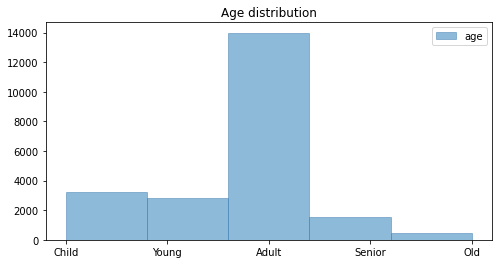

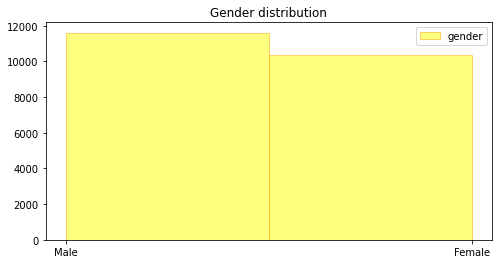

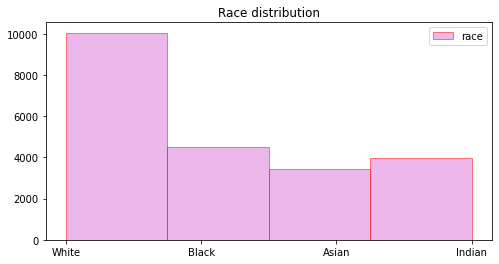

In [12]:
# PLOT DISTRIBUTIONS

def plot_distr(df):
    age = df["age"].astype(int).sort_values()
    age_bins=len(age.value_counts())

    gender = df["gender"].astype(int).sort_values()
    gender_bins=len(gender.value_counts())

    race = df["race"].astype(int).sort_values()
    race_bins=len(race.value_counts())

    age.hist(bins=age_bins, figsize=[8,4], edgecolor='steelblue', 
            linewidth=1, grid=False, alpha=0.5, legend=True)
    plt.title('Age distribution')
    plt.xticks(np.arange(0, 5, step=1), ['Child', 'Young', 'Adult', 'Senior', 'Old'])
    plt.show()

    gender.hist(bins=gender_bins, figsize=[8,4], edgecolor='orange', 
                linewidth=1, grid=False, alpha=0.5, legend=True, color='yellow')
    plt.title('Gender distribution')
    plt.xticks(np.arange(0, 2, step=1), ['Male', 'Female'])
    plt.show()

    race.hist(bins=race_bins, figsize=[8,4], edgecolor='red', 
              linewidth=1, grid=False, alpha=0.5, legend=True, color='orchid')
    plt.xticks(np.arange(0, 4, step=1), ['White', 'Black', 'Asian', 'Indian'])
    plt.title('Race distribution')
    plt.show()


plot_distr(utkface_df)

In [13]:
# SAVE ANALYSED DATA

list_utkface = os.listdir(UTKFACE_DIR)
if ('utkface_df.csv' in list_utkface):
    print('CSVs already present')
else:
  # utkface_df ATTRIBUTES CSV 
  utkface_df.to_csv(UTKFACE_DF_CSV_PATH) 

CSVs already present


###Training GAN preparation
Data for training to create synthetic images

In [14]:
# CLONE DF

to_train_df = utkface_df.copy()
to_train_df.head(5)

,age,gender,race
37_0_3_20170119202516470.jpg.chip.jpg,2,0,3
15_0_0_20170110225705232.jpg.chip.jpg,1,0,0
45_0_3_20170119171425106.jpg.chip.jpg,2,0,3
53_0_3_20170119201334485.jpg.chip.jpg,2,0,3
22_0_1_20170113193211629.jpg.chip.jpg,1,0,1


In [15]:
# ONE HOT ENCODING

def one_hot_enc(df):
    df_one_hot_enc = pd.get_dummies(df, 
                                columns=["age", "gender", "race"], 
                                dtype=float)
    df_one_hot_enc = df_one_hot_enc.rename({'age_0' : 'child', 
                                            'age_1' : 'young', 
                                            'age_2' : 'adult', 
                                            'age_3' : 'senior', 
                                            'age_4' : 'old', 
                                            'gender_0' : 'male', 
                                            'gender_1' : 'female', 
                                            'race_0' : 'white', 
                                            'race_1' : 'black', 
                                            'race_2' : 'asian',
                                            'race_3' : 'indian'}, 
                                             axis=1)
    return df_one_hot_enc

to_train_df = one_hot_enc(to_train_df)
#utkface_bal = one_hot_enc(utkface_bal)
to_train_df.head(5)

,child,young,adult,senior,old,male,female,white,black,asian,indian
37_0_3_20170119202516470.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
15_0_0_20170110225705232.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
53_0_3_20170119201334485.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22_0_1_20170113193211629.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [16]:
# FEMALE CLASS DROP (REMOVE REDUDANCE)

to_train_df = to_train_df.drop(columns=['female'])
#utkface_bal = utkface_bal.drop(columns=['female'])
to_train_df.head()

,child,young,adult,senior,old,male,white,black,asian,indian
37_0_3_20170119202516470.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
15_0_0_20170110225705232.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
45_0_3_20170119171425106.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
53_0_3_20170119201334485.jpg.chip.jpg,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
22_0_1_20170113193211629.jpg.chip.jpg,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [17]:
# SAVE UTKFACE ONE-HOT ENC DATA

list_utkface = os.listdir(UTKFACE_DIR)
if ('utkface_ohe.csv' in list_utkface):
    print('CSVs already present')
else:
  # utkface_df_ohe CSV 
  to_train_df.to_csv(UTKFACE_OHE_PATH) 

CSVs already present


In [18]:
# SAVE DATA FOR TRAINING 
attr_dict = to_train_df.to_json(orient='index')
with open(UTKFACE_ATTR_PATH, 'w') as outfile:
    json.dump(json.loads(attr_dict), outfile)

## Age Race Gender Recognition




### Method 1: MLP

Source: https://github.com/wondonghyeon/face-classification/blob/master/train.ipynb


MODEL_CHKP_CNN_PATH = "/content/drive/MyDrive/AGR_recognition/CNN_face_model"

MODEL_CHKP_MLP_PATH = '/content/drive/MyDrive/AGR_recognition/MLP_face_model.pkl'

In [ ]:
# LOAD MLP DATA
to_train_df = pd.read_csv(UTKFACE_OHE_PATH, index_col=0)

In [18]:
# CSV FEATURE AND LABEL CREATION FOR MLP

list_utkface = os.listdir(UTKFACE_DIR)
if ('feature.csv' in list_utkface and 'label.csv' in list_utkface):
  print('CSVs already present')
else:
  vecs = []
  fnames = []
  i = 0
  for fname in tqdm(to_train_df.index): 
      i += 1
      img_path = UTKFACE_PATH + '/' + fname
      X_img = face_recognition.load_image_file(img_path)
      X_faces_loc = face_locations(X_img)
      if len(X_faces_loc) != 1:
          continue
      faces_encoding = face_recognition.face_encodings(X_img, known_face_locations=X_faces_loc)[0]
      vecs.append(faces_encoding)
      fnames.append(fname)
      
  df_feat = pd.DataFrame(vecs, index=fnames)
  df_label = to_train_df[to_train_df.index.isin(df_feat.index)]
  df_feat.sort_index(inplace=True)
  df_label.sort_index(inplace=True)
  df_feat.to_csv(UTKFACE_FEATURE_CSV_PATH)
  df_label.to_csv(UTKFACE_LABEL_CSV_PATH)

CSVs already present


In [ ]:
df_feat.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
100_0_0_20170112213500903.jpg.chip.jpg,-0.150687,0.017762,0.009022,-0.020210,-0.034357,-0.051800,0.026554,-0.088148,0.064197,-0.000041,0.188830,-0.032655,-0.199288,-0.073831,0.014807,0.069385,-0.108062,-0.094468,-0.190144,-0.062333,-0.034651,0.027099,0.017674,-0.049138,-0.112850,-0.316572,-0.084049,-0.136261,-0.060343,-0.072813,0.156838,0.004264,-0.261348,-0.101612,0.016725,0.008088,-0.038148,-0.090217,0.172343,0.070515,...,0.187625,0.028034,-0.105154,0.209194,-0.094128,-0.092112,0.023758,-0.002826,-0.087360,-0.055187,-0.006142,-0.074895,0.086983,-0.132743,-0.044538,0.059878,-0.226604,0.096543,-0.012086,-0.015789,0.067997,-0.051150,0.017352,0.036976,0.115027,-0.228637,0.240849,0.151428,-0.115480,0.110388,0.005165,0.027262,-0.076492,0.067850,-0.139905,-0.121399,0.010408,0.052814,0.070204,-0.004858
100_0_0_20170112215240346.jpg.chip.jpg,-0.111628,0.020461,0.041261,0.096129,-0.146715,-0.057401,0.021027,-0.092045,0.136468,-0.050770,0.167688,-0.098843,-0.235864,-0.043552,0.004002,0.142021,-0.121766,-0.111055,-0.108438,-0.121923,-0.020995,0.006052,0.004066,-0.032264,-0.123306,-0.295595,-0.083147,-0.077075,0.083640,-0.091091,0.040476,0.098237,-0.297848,-0.195524,0.021467,0.092104,-0.077535,-0.058177,0.232847,0.043153,...,0.222774,0.000324,-0.027434,0.144216,-0.019668,-0.129577,0.042710,0.040456,-0.093765,-0.104191,-0.145742,-0.043724,0.028382,-0.164331,0.042527,0.130327,-0.247607,0.107205,-0.032848,-0.069319,-0.048443,-0.072356,-0.106415,0.091274,0.182433,-0.236044,0.217322,0.134483,-0.090570,0.094415,0.011330,0.040189,-0.113148,-0.017252,-0.122524,-0.169552,-0.003611,0.010955,0.097745,0.075278
100_1_0_20170110183726390.jpg.chip.jpg,-0.090764,0.080692,-0.036722,-0.019773,-0.131882,-0.005636,-0.023710,-0.084573,0.166797,-0.091787,0.099192,0.009816,-0.241623,0.015316,0.001029,0.113348,-0.125438,-0.092608,-0.190358,-0.174489,-0.041487,0.065134,0.008672,-0.016963,-0.178868,-0.245161,-0.094349,-0.057054,0.042644,-0.070740,0.028564,0.021316,-0.272059,-0.118062,0.075568,0.042905,-0.047660,-0.012868,0.295126,0.080353,...,0.174211,0.038160,-0.016576,0.158068,0.041219,0.034578,-0.024417,0.076665,-0.210161,-0.165055,-0.095769,-0.009546,0.046704,-0.092851,0.064891,0.147553,-0.190611,0.188730,-0.007450,-0.066952,-0.048399,0.055428,-0.044594,0.011550,0.098651,-0.241636,0.238836,0.097690,-0.103715,0.070319,0.064228,0.032946,-0.040264,0.056799,-0.147145,-0.199948,0.002343,-0.028861,0.111737,0.039684
100_1_0_20170112213001988.jpg.chip.jpg,-0.188170,0.017694,0.039001,-0.058659,-0.090922,-0.013029,0.043942,-0.093032,0.193557,-0.094195,0.128479,-0.021825,-0.231139,0.045674,-0.027354,0.200347,-0.109402,-0.157259,-0.112664,-0.089877,-0.027701,0.081340,-0.017114,0.020354,-0.114206,-0.281783,-0.051733,-0.043457,-0.000517,0.000888,-0.002560,0.079013,-0.269013,-0.016085,0.060864,0.108936,-0.119098,-0.080656,0.304028,0.052373,...,0.273221,-0.019045,0.025622,0.181381,-0.009868,-0.005642,-0.044313,0.092416,-0.145644,-0.098311,-0.072426,-0.063842,0.008231,-0.078691,0.017511,0.150207,-0.247286,0.188000,-0.039258,-0.036636,0.023100,-0.041116,-0.032413,-0.010400,0.082949,-0.203148,0.228695,0.079541,-0.101684,0.152575,0.067967,0.073297,-0.039873,0.056338,-0.194292,-0.127998,0.103995,0.036266,0.090717,0.063506
100_1_0_20170112213303693.jpg.chip.jpg,-0.145160,0.039837,0.049270,-0.108189,-0.052100,-0.035279,0.059941,-0.124384,0.188829,-0.140649,0.150448,-0.109694,-0.251839,-0.040736,-0.040397,0.210893,-0.228008,-0.135143,-0.176345,-0.189171,0.013534,0.129730,-0.040824,0.000817,-0.179937,-0.320385,-0.056286,-0.072498,0.020444,-0.041524,0.031471,0.121815,-0.246490,-0.042845,0.055886,0.116871,-0.078620,-0.104700,0.234784,0.041613,...,0.230631,-0.018167,0.020107,0.217519,-0.045191,0.009077,-0.035443,0.054403,-0.1900

In [ ]:
df_label.head(5)

,child,young,adult,senior,old,male,white,black,asian,indian
100_0_0_20170112213500903.jpg.chip.jpg,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
100_0_0_20170112215240346.jpg.chip.jpg,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
100_1_0_20170110183726390.jpg.chip.jpg,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
100_1_0_20170112213001988.jpg.chip.jpg,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
100_1_0_20170112213303693.jpg.chip.jpg,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [21]:
# DATASET SPLIT MLP

# load features and labels
df_feat = pd.read_csv(UTKFACE_FEATURE_CSV_PATH, index_col=0)
df_label = pd.read_csv(UTKFACE_LABEL_CSV_PATH, index_col=0)

# load utkface_df
cnn_df = pd.read_csv(UTKFACE_DF_CSV_PATH, index_col=0)

# split training/test name
idx_train, idx_test = train_test_split(df_feat.index, test_size = 0.30, random_state = 123)

# train/test for MLP
X_train_mlp, Y_train_mlp = df_feat.loc[idx_train], df_label.loc[idx_train]
X_test_mlp, Y_test_mlp = df_feat.loc[idx_test], df_label.loc[idx_test]

print('Number of total samples:         ', df_label.shape[0])
print('Number of elements in train set: ', idx_train.shape[0])
print('Number of elements in test set:  ', idx_test.shape[0])

Number of total samples:          21185
Number of elements in train set:  14829
Number of elements in test set:   6356


[2162, 1942, 9453, 996, 276, 7822, 6815, 2995, 2296, 2723]


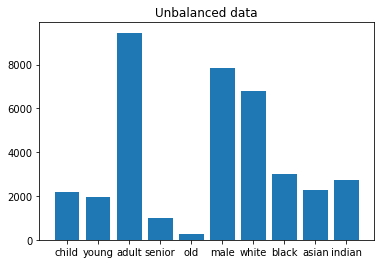

In [ ]:
# DATA VISUALIZATION MLP
attr_count = []
for col in Y_train_mlp.columns:
  attr_count.append(Y_train_mlp[col].astype(int).value_counts()[1])

print(attr_count)

plt.bar(Y_train_mlp.columns, attr_count)
plt.title('Unbalanced data')
plt.show()

In [ ]:
# MLP CLASSIFIER 

if 'MLP_face_model.pkl' not in os.listdir('/content/drive/MyDrive/AGR_recognition/'):
  clf = MLPClassifier(solver='adam', 
                      hidden_layer_sizes=(128, 128),
                      max_iter = 5000, 
                      verbose=True, 
                      tol=1e-4, 
                      activation='relu')
  print(Y_train_mlp.head())
  clf.fit(X_train_mlp, Y_train_mlp)

  # save model
  with open(MODEL_CHKP_MLP_PATH, 'wb') as f:
      pickle.dump([clf, df_label.columns.tolist()], f)
      label_list = df_label.columns.tolist()

else:
  clf, label_list = pickle.load(open(MODEL_CHKP_MLP_PATH,'rb'))


# MLP model prediction
pred = clf.predict(X_test_mlp)
score = clf.predict_proba(X_test_mlp)

df_pred = pd.DataFrame(pred, columns=label_list, index=Y_test_mlp.index)
df_score = pd.DataFrame(score, columns=label_list, index=Y_test_mlp.index)

                                       child  young  ...  asian  indian
30_1_2_20170105170141222.jpg.chip.jpg    0.0    0.0  ...    1.0     0.0
25_0_0_20170116211924733.jpg.chip.jpg    0.0    0.0  ...    0.0     0.0
2_0_2_20161219191202354.jpg.chip.jpg     1.0    0.0  ...    1.0     0.0
3_1_0_20161219225130536.jpg.chip.jpg     1.0    0.0  ...    0.0     0.0
36_0_0_20170104174512284.jpg.chip.jpg    0.0    0.0  ...    0.0     0.0

[5 rows x 10 columns]
Iteration 1, loss = 4.66478508
Iteration 2, loss = 2.94393002
Iteration 3, loss = 2.17050113
Iteration 4, loss = 1.91624816
Iteration 5, loss = 1.80368698
Iteration 6, loss = 1.74183949
Iteration 7, loss = 1.70149456
Iteration 8, loss = 1.66698213
Iteration 9, loss = 1.64547498
Iteration 10, loss = 1.61500235
Iteration 11, loss = 1.59393094
Iteration 12, loss = 1.58341144
Iteration 13, loss = 1.56484545
Iteration 14, loss = 1.55306930
Iteration 15, loss = 1.54298338
Iteration 16, loss = 1.52594778
Iteration 17, loss = 1.52075563
Iteration 

In [ ]:
# MLP METRICS
cm_age = confusion_matrix(Y_test_mlp.iloc[:, :4].values.argmax(axis=1), 
                          df_pred.iloc[:, :4].values.argmax(axis=1))
cm_gen = confusion_matrix(Y_test_mlp.iloc[:, 4:5].values.argmax(axis=1), 
                          df_pred.iloc[:, 4:5].values.argmax(axis=1))
cm_race = confusion_matrix(Y_test_mlp.iloc[:, 5:].values.argmax(axis=1), 
                           df_pred.iloc[:, 5:].values.argmax(axis=1))

report = classification_report(Y_test_mlp.values, 
                               df_pred.values, 
                               target_names=Y_test_mlp.columns)

print('CM AGE:\n', cm_age)
print('\nCM GEN:\n', cm_gen)
print('\nCM RACE:\n', cm_race)

print('\nREPORT:\n', report)

CM AGE:
 [[ 892   43   36   48]
 [  67  329  423    0]
 [  92  368 3482  122]
 [  61    8  231  154]]

CM GEN:
 [[6356]]

CM RACE:
 [[3136   86   29   58   24]
 [ 139 1132   38   20   47]
 [  44   20  546    5    8]
 [  77   16    4  437    4]
 [  65   43   27    5  346]]

REPORT:
               precision    recall  f1-score   support

       child       0.93      0.92      0.92       886
       young       0.44      0.40      0.42       819
       adult       0.83      0.86      0.85      4064
      senior       0.46      0.39      0.42       454
         old       0.56      0.50      0.53       133
        male       0.93      0.94      0.93      3333
       white       0.93      0.90      0.92      2978
       black       0.89      0.92      0.90      1268
       asian       0.92      0.92      0.92       986
      indian       0.83      0.82      0.82      1124

   micro avg       0.86      0.85      0.85     16045
   macro avg       0.77      0.76      0.76     16045
weighted avg 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Method 2: CNN

Source: https://github.com/Sobika2531/Age-Gender-And-Race-Detection-Using-CNN/blob/main/AGRdetector.ipynb

In [19]:
# CNN
def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, 
               kernel_size=3, 
               activation='relu', 
               padding='same')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(200, 200, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=5, 
                   activation='softmax', 
                   name='age_output')(_)
# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=2, 
                      activation='softmax', 
                      name='gender_output')(_)
# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=4, 
                    activation='softmax', 
                    name='race_output')(_)

In [20]:
# DATA TO TRAIN
def get_data_generator(df, for_training, batch_size=16):
    images, ages, genders, races = [], [], [], []
    while True:
        for i in range(len(df)):
            r = df.iloc[i]
            file, age, gender, race = r.name, r['age'], r['gender'], r['race']
            path = Path(UTKFACE_PATH, file)
            im = Image.open(str(path))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(to_categorical(age, 5))
            genders.append(to_categorical(gender, 2))
            races.append(to_categorical(race, 4))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(genders), np.array(races)]
                images, ages, genders, races = [], [], [], []
        if not for_training:
            break

#### Unbalanced

In [19]:
# split training/testing/validation
X_train_cnn, X_test_cnn = train_test_split(utkface_df, test_size = 0.30, random_state = 123)
X_test_cnn, X_val_cnn = train_test_split(X_test_cnn, test_size = 0.25, random_state = 123)

print('Number of total samples:         ', utkface_df.shape[0])
print('Number of elements in train set: ', X_train_cnn.shape[0])
print('Number of elements in test set:  ', X_test_cnn.shape[0])
print('Number of elements in val set:   ', X_val_cnn.shape[0])

Number of total samples:          21981
Number of elements in train set:  15386
Number of elements in test set:   4946
Number of elements in val set:    1649


In [20]:
X_test_cnn.head()

,age,gender,race
35_0_0_20170117123744051.jpg.chip.jpg,2,0,0
23_1_0_20170103180703224.jpg.chip.jpg,1,1,0
37_1_0_20170105000536252.jpg.chip.jpg,2,1,0
28_0_1_20170117015429533.jpg.chip.jpg,2,0,1
23_1_2_20170116172852744.jpg.chip.jpg,1,1,2


In [21]:
X_train_cnn.head()

,age,gender,race
26_0_1_20170116193423469.jpg.chip.jpg,2,0,1
24_1_0_20170117150535820.jpg.chip.jpg,1,1,0
46_0_2_20170116192700927.jpg.chip.jpg,2,0,2
10_0_0_20170110225414790.jpg.chip.jpg,0,0,0
31_1_2_20170109003538257.jpg.chip.jpg,2,1,2


In [22]:
X_val_cnn.head()

,age,gender,race
61_0_1_20170117194549667.jpg.chip.jpg,2,0,1
35_1_1_20170113195518309.jpg.chip.jpg,2,1,1
39_1_0_20170105003308781.jpg.chip.jpg,2,1,0
35_0_0_20170117172452115.jpg.chip.jpg,2,0,0
26_1_0_20170117091502729.jpg.chip.jpg,2,1,0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 64  18496       ['conv2d[0][0]']                 
                                )                                                             

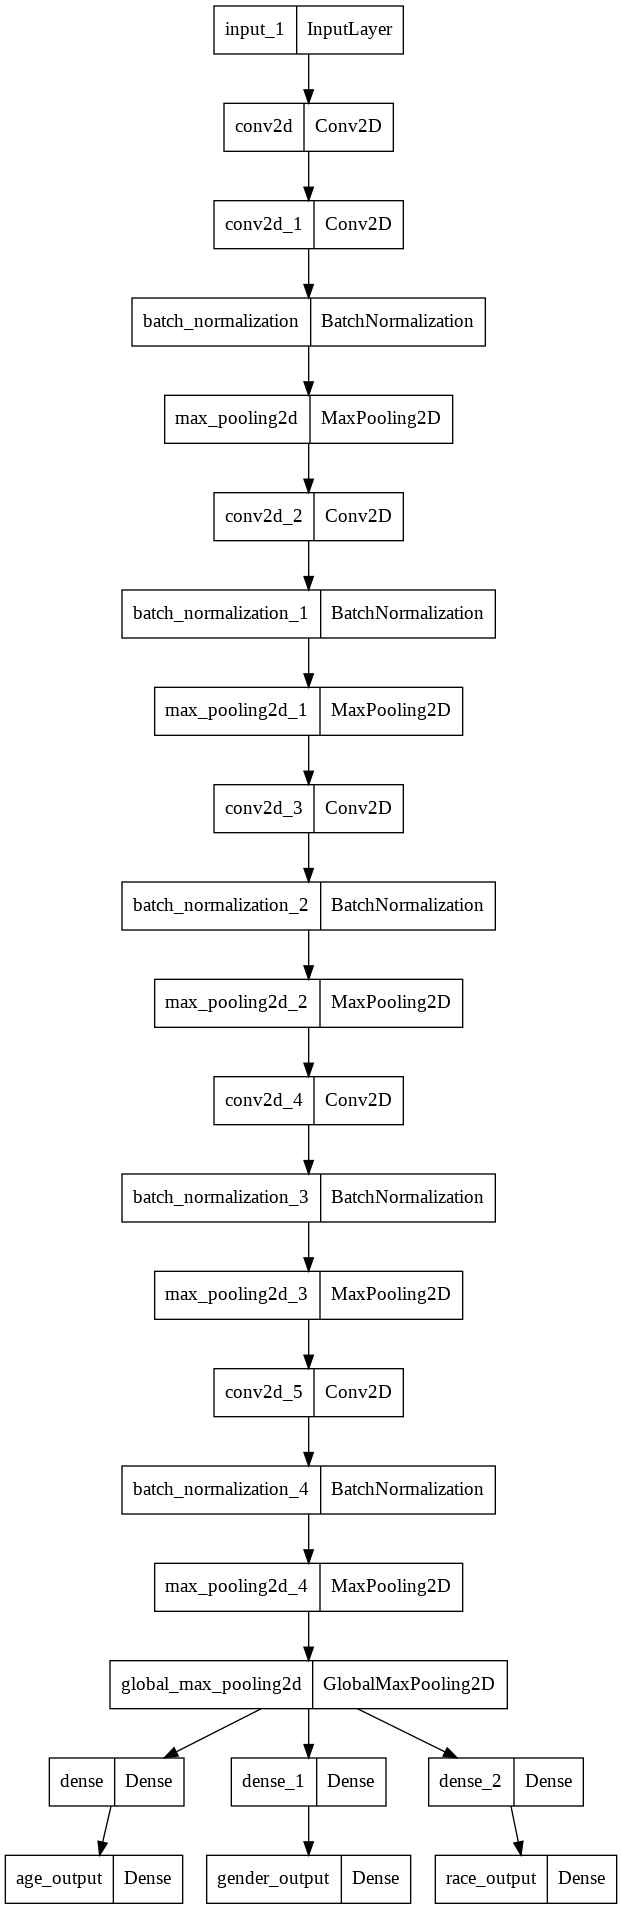

In [23]:
# model declaretion 
model_unbal = Model(inputs=input_layer, 
                    outputs=[age_output, gender_output, race_output])
              
model_unbal.compile(optimizer='rmsprop', 
                    loss={'age_output': 'categorical_crossentropy',
                          'gender_output': 'categorical_crossentropy', 
                          'race_output': 'categorical_crossentropy'},
                    loss_weights={'age_output': 1, 
                                  'gender_output': 1,
                                  'race_output': 1},
                    metrics={'age_output': 'accuracy', 
                              'gender_output': 'accuracy', 
                              'race_output': 'accuracy'})
model_unbal.summary()
plot_model(model_unbal, "Unbalanced model.png")

In [23]:
# Data preparartion for training

batch_size = 64
train_gen = get_data_generator(X_train_cnn, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(X_val_cnn, for_training=True, batch_size=batch_size)
test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=batch_size)

In [38]:
# TRAINING
callbacks = [ModelCheckpoint(MODEL_CHKP_CNN_PATH, monitor='val_loss')]

history = model_unbal.fit(train_gen,
                          epochs=10,
                          steps_per_epoch=len(X_train_cnn)//batch_size,
                          callbacks=callbacks,
                          validation_data=valid_gen,
                          validation_steps=len(X_val_cnn)//batch_size)

Epoch 1/10
240/240 [==============================] - 158s 583ms/step - loss: 2.9476 - age_output_loss: 1.0395 - gender_output_loss: 0.6713 - race_output_loss: 1.2368 - age_output_accuracy: 0.6548 - gender_output_accuracy: 0.6751 - race_output_accuracy: 0.5258 - val_loss: 4.9516 - val_age_output_loss: 2.0387 - val_gender_output_loss: 0.9743 - val_race_output_loss: 1.9386 - val_age_output_accuracy: 0.1994 - val_gender_output_accuracy: 0.5350 - val_race_output_accuracy: 0.4725
Epoch 2/10
240/240 [==============================] - 133s 555ms/step - loss: 1.8758 - age_output_loss: 0.7321 - gender_output_loss: 0.4030 - race_output_loss: 0.7407 - age_output_accuracy: 0.7263 - gender_output_accuracy: 0.8145 - race_output_accuracy: 0.7127 - val_loss: 1.8595 - val_age_output_loss: 0.7844 - val_gender_output_loss: 0.3563 - val_race_output_loss: 0.7187 - val_age_output_accuracy: 0.7262 - val_gender_output_accuracy: 0.8450 - val_race_output_accuracy: 0.7063
Epoch 3/10
240/240 [====================

In [39]:
# SAVE HISTORY
with open(MODEL_CHKP_CNN_PATH + '/cnn_history.pkl', 'wb') as f:
    pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://465d89a8-c8ac-4a21-b93a-14839f327625/assets


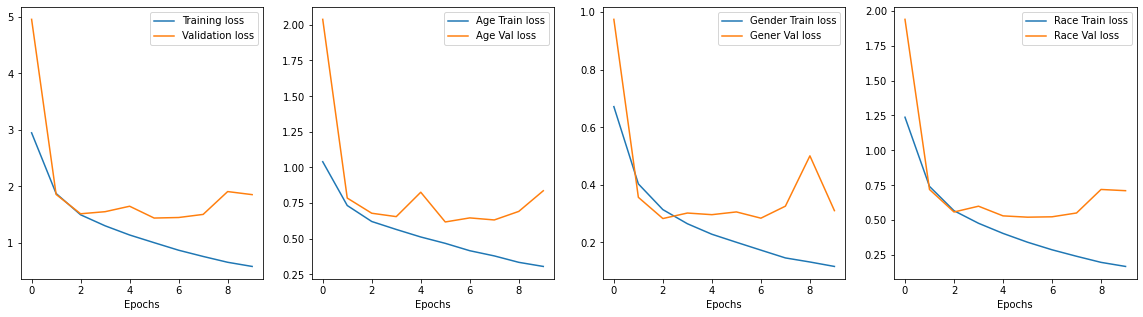

In [21]:
# PLOT LOSSES
def  plot_train_loss(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # total loss
    axes[0].plot(history.history['loss'], label='Training loss')
    axes[0].plot(history.history['val_loss'], label='Validation loss')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()

    # age loss
    axes[1].plot(history.history['age_output_loss'], label='Age Train loss')
    axes[1].plot(history.history['val_age_output_loss'], label='Age Val loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend() 

    # gender loss
    axes[2].plot(history.history['gender_output_loss'], label='Gender Train loss')
    axes[2].plot(history.history['val_gender_output_loss'], label='Gener Val loss')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()

    # race loss
    axes[3].plot(history.history['race_output_loss'], label='Race Train loss')
    axes[3].plot(history.history['val_race_output_loss'], label='Race Val loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()
try: 
  if history:
    plot_train_loss(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '/cnn_history.pkl','rb'))
  plot_train_loss(h)

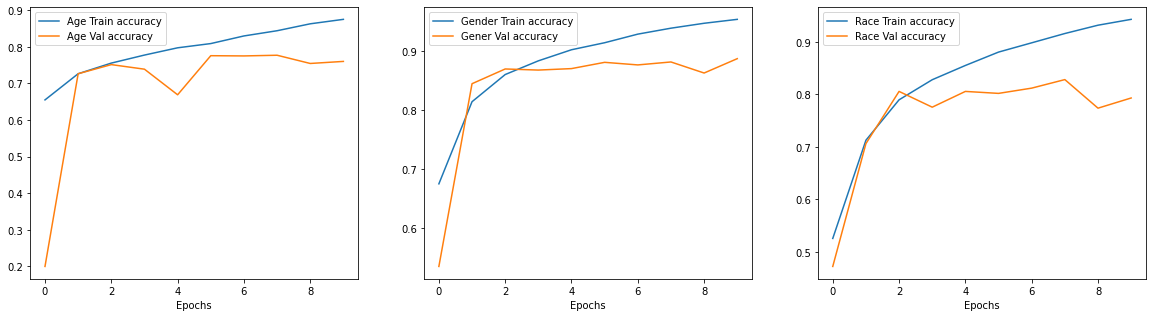

In [22]:
# PLOT ACCURACY
def  plot_train_accuracy(history):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # age accuracy
    axes[0].plot(history.history['age_output_accuracy'], label='Age Train accuracy')
    axes[0].plot(history.history['val_age_output_accuracy'], label='Age Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    # gender accuracy
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    # race accuracy
    axes[2].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[2].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()
try: 
  if history:
    plot_train_accuracy(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '/cnn_history.pkl','rb'))
  plot_train_accuracy(h)

In [37]:
# LOAD MODEL (only if necessary)
model_unbal = load_model(MODEL_CHKP_CNN_PATH, compile=True)
batch_size = 128
test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=batch_size)

In [45]:
# TEST 
dict(zip(model_unbal.metrics_names, 
         model_unbal.evaluate(test_gen, steps=len(X_test_cnn)//batch_size)))

77/77 [==============================] - 2s 24ms/step - loss: 1.6069 - age_output_loss: 0.6881 - gender_output_loss: 0.2972 - race_output_loss: 0.6215 - age_output_accuracy: 0.7969 - gender_output_accuracy: 0.8984 - race_output_accuracy: 0.8031


{'age_output_accuracy': 0.796875,
 'age_output_loss': 0.6881169676780701,
 'gender_output_accuracy': 0.8984375,
 'gender_output_loss': 0.2972262501716614,
 'loss': 1.6068804264068604,
 'race_output_accuracy': 0.8031250238418579,
 'race_output_loss': 0.6215372681617737}

In [38]:
# METRICS
#test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=len(X_test_cnn))
x_test, attr_list = next(test_gen)

age_pred, gender_pred, race_pred = model_unbal.predict_on_batch(x_test)

age_true, gender_true, race_true = attr_list[0].argmax(axis=-1), attr_list[1].argmax(axis=-1), attr_list[2].argmax(axis=-1)
age_pred, gedner_pred, race_pred = age_pred.argmax(axis=-1), gender_pred.argmax(axis=-1), race_pred.argmax(axis=-1)

In [23]:
def normalize_gender_prediction(gender_pred):
    gender_pred_norm = []
    for prediction in gender_pred:
      if prediction[0] > prediction[1]:
        gender_pred_norm.append(0)
      else:
        gender_pred_norm.append(1)
    return np.array(gender_pred_norm)

In [40]:
from sklearn.metrics import classification_report
print("Classification report for age")
print(classification_report(age_true, age_pred))

print("\nClassification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, normalize_gender_prediction(gender_pred)))

Classification report for age
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        20
           1       0.57      0.18      0.28        22
           2       0.74      0.94      0.82        78
           3       0.20      0.20      0.20         5
           4       1.00      0.67      0.80         3

    accuracy                           0.74       128
   macro avg       0.70      0.55      0.59       128
weighted avg       0.74      0.74      0.71       128


Classification report for race
              precision    recall  f1-score   support

           0       0.96      0.79      0.87        70
           1       0.79      0.86      0.83        22
           2       0.70      0.88      0.78        16
           3       0.59      0.80      0.68        20

    accuracy                           0.81       128
   macro avg       0.76      0.83      0.79       128
weighted avg       0.84      0.81      0.82       128


Classificatio

####Balanced

In [24]:
# BALANCING

# Groupby for columns: it returns 40 combinations
# Resampling with 400 items for group, with replacement and a specific seed

utkface_bal = utkface_df.copy()
utkface_bal = utkface_bal.groupby(['gender', 'race', 'age']).sample(400, replace=True, random_state=123)
utkface_bal.groupby(['gender', 'race', 'age']).size()

gender  race  age
0       0     0      400
              1      400
              2      400
              3      400
              4      400
        1     0      400
              1      400
              2      400
              3      400
              4      400
        2     0      400
              1      400
              2      400
              3      400
              4      400
        3     0      400
              1      400
              2      400
              3      400
              4      400
1       0     0      400
              1      400
              2      400
              3      400
              4      400
        1     0      400
              1      400
              2      400
              3      400
              4      400
        2     0      400
              1      400
              2      400
              3      400
              4      400
        3     0      400
              1      400
              2      400
              3      400
       

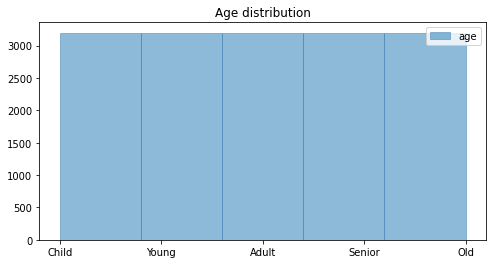

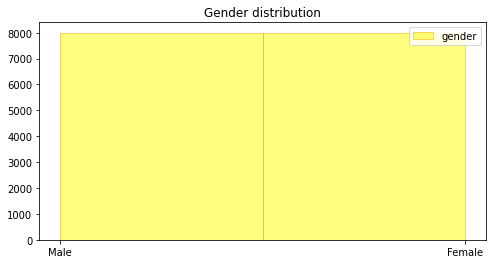

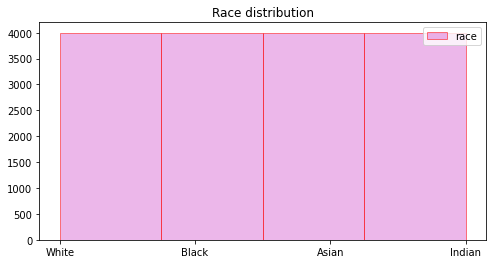

In [42]:
# DISTRIBUTIONS AFTER BALANCING 
plot_distr(utkface_bal)

In [43]:
utkface_bal.head()

,age,gender,race
8_0_0_20170110220350538.jpg.chip.jpg,0,0,0
7_0_0_20170110215645684.jpg.chip.jpg,0,0,0
4_0_0_20170110213542396.jpg.chip.jpg,0,0,0
5_0_0_20170110215925587.jpg.chip.jpg,0,0,0
10_0_0_20170110221811823.jpg.chip.jpg,0,0,0


In [44]:
# SAVE BALANCED DATA 
attr_dict_bal = utkface_bal.to_csv('attr_bal.csv')

In [25]:
# split training/testing/validation
X_train_bal, X_test_bal = train_test_split(utkface_bal, test_size = 0.30, random_state = 123)
X_test_bal, X_val_bal = train_test_split(X_test_bal, test_size = 0.25, random_state = 123)

print('Number of total samples:         ', utkface_bal.shape[0])
print('Number of elements in train set: ', X_train_bal.shape[0])
print('Number of elements in test set:  ', X_test_bal.shape[0])
print('Number of elements in val set:   ', X_val_bal.shape[0])

Number of total samples:          16000
Number of elements in train set:  11200
Number of elements in test set:   3600
Number of elements in val set:    1200


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 200, 200, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 200, 200, 64  18496       ['conv2d[0][0]']                 
                                )                                                           

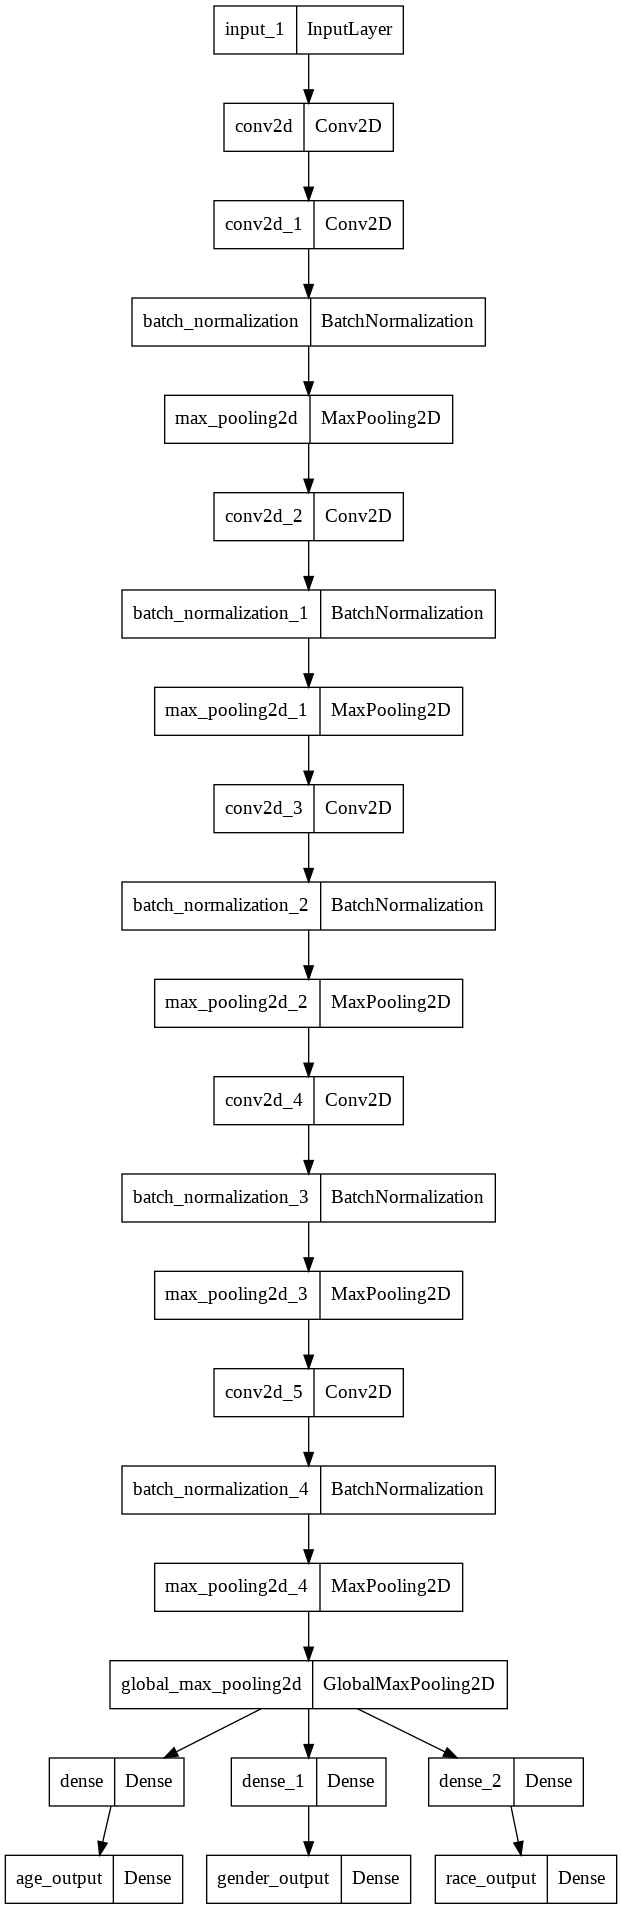

In [47]:
model_bal = Model(inputs=input_layer, 
                  outputs=[age_output, gender_output, race_output])
              
model_bal.compile(optimizer='rmsprop', 
                  loss={'age_output': 'categorical_crossentropy',
                        'gender_output': 'categorical_crossentropy', 
                        'race_output': 'categorical_crossentropy'},
                  loss_weights={'age_output': 1, 
                                'gender_output': 1,
                                'race_output': 1},
                  metrics={'age_output': 'accuracy', 
                          'gender_output': 'accuracy', 
                          'race_output': 'accuracy'})
model_bal.summary()
plot_model(model_bal, "model_bal.png")

In [26]:
# Data preparartion for training

batch_size = 64
train_gen_bal = get_data_generator(X_train_bal, for_training=True, batch_size=batch_size)
valid_gen_bal = get_data_generator(X_val_bal, for_training=True, batch_size=batch_size)
test_gen_bal = get_data_generator(X_test_bal, for_training=False, batch_size=batch_size)

In [50]:
# TRAINING
callbacks = [ModelCheckpoint(MODEL_CHKP_CNN_PATH + '_bal', monitor='val_loss')]

history = model_bal.fit(train_gen_bal,
                        epochs=10,
                        steps_per_epoch=len(X_train_bal)//batch_size,
                        callbacks=callbacks,
                        validation_data=valid_gen_bal,
                        validation_steps=len(X_val_bal)//batch_size)

Epoch 1/10
175/175 [==============================] - 123s 654ms/step - loss: 3.6087 - age_output_loss: 1.4472 - gender_output_loss: 0.7948 - race_output_loss: 1.3667 - age_output_accuracy: 0.4163 - gender_output_accuracy: 0.6056 - race_output_accuracy: 0.4401 - val_loss: 5.1251 - val_age_output_loss: 2.0470 - val_gender_output_loss: 1.0023 - val_race_output_loss: 2.0758 - val_age_output_accuracy: 0.2552 - val_gender_output_accuracy: 0.4965 - val_race_output_accuracy: 0.3212
Epoch 2/10
175/175 [==============================] - 105s 598ms/step - loss: 2.2442 - age_output_loss: 0.8858 - gender_output_loss: 0.5214 - race_output_loss: 0.8371 - age_output_accuracy: 0.6233 - gender_output_accuracy: 0.7435 - race_output_accuracy: 0.6653 - val_loss: 3.9629 - val_age_output_loss: 1.3522 - val_gender_output_loss: 1.0233 - val_race_output_loss: 1.5874 - val_age_output_accuracy: 0.4201 - val_gender_output_accuracy: 0.5069 - val_race_output_accuracy: 0.3689
Epoch 3/10
175/175 [====================

In [51]:
# SAVE HISTORY
with open(MODEL_CHKP_CNN_PATH + '_bal' + '/cnn_history.pkl', 'wb') as f:
    pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://e2542a68-b520-454c-b76c-0e2083f03b13/assets


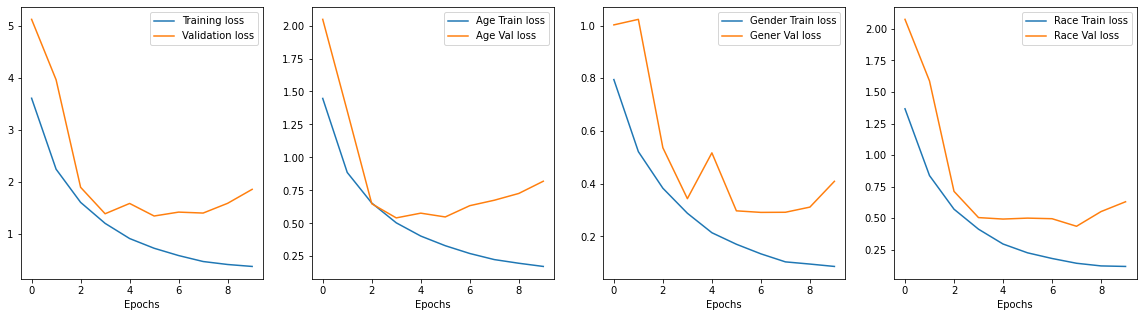

In [27]:
# PLOT LOSSES
try: 
  if history:
    plot_train_loss(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '_bal' + '/cnn_history.pkl','rb'))
  plot_train_loss(h)

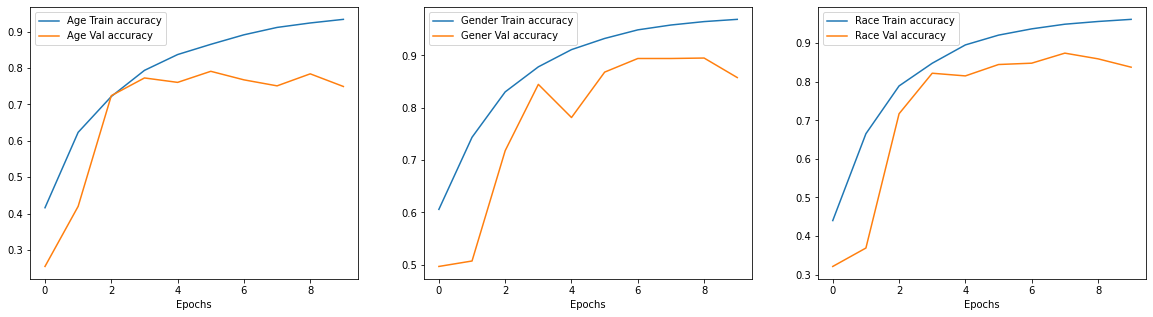

In [29]:
# PLOT ACCURACY
try: 
  if history:
    plot_train_accuracy(history)
except NameError:
  h = pickle.load(open(MODEL_CHKP_CNN_PATH + '_bal' + '/cnn_history.pkl','rb'))
  plot_train_accuracy(h)

In [33]:
# LOAD MODEL (only if necessary)
model_bal = load_model(MODEL_CHKP_CNN_PATH + '_bal', compile=True)
batch_size = 128
test_gen_bal = get_data_generator(X_test_bal, for_training=False, batch_size=batch_size)

In [31]:
# TEST 
dict(zip(model_bal.metrics_names, 
         model_bal.evaluate(test_gen_bal, steps=len(X_test_bal)//batch_size)))

28/28 [==============================] - 28s 436ms/step - loss: 1.8947 - age_output_loss: 0.7873 - gender_output_loss: 0.4759 - race_output_loss: 0.6315 - age_output_accuracy: 0.7556 - gender_output_accuracy: 0.8491 - race_output_accuracy: 0.8354


{'age_output_accuracy': 0.7555803656578064,
 'age_output_loss': 0.7872907519340515,
 'gender_output_accuracy': 0.8490513563156128,
 'gender_output_loss': 0.4758601188659668,
 'loss': 1.8946729898452759,
 'race_output_accuracy': 0.8353794813156128,
 'race_output_loss': 0.6315220594406128}

In [34]:
# METRICS
#test_gen = get_data_generator(X_test_cnn, for_training=False, batch_size=len(X_test_cnn))
x_test_bal, attr_list_bal = next(test_gen_bal)

age_pred_bal, gender_pred_bal, race_pred_bal = model_bal.predict_on_batch(x_test_bal)

age_true_bal, gender_true_bal, race_true_bal = attr_list_bal[0].argmax(axis=-1), attr_list_bal[1].argmax(axis=-1), attr_list_bal[2].argmax(axis=-1)
age_pred_bal, gedner_pred_bal, race_pred_bal = age_pred_bal.argmax(axis=-1), gender_pred_bal.argmax(axis=-1), race_pred_bal.argmax(axis=-1)

In [35]:
from sklearn.metrics import classification_report
print("Classification report for age")
print(classification_report(age_true_bal, age_pred_bal))

print("\nClassification report for race")
print(classification_report(race_true_bal, race_pred_bal))

print("\nClassification report for gender")
print(classification_report(gender_true_bal, normalize_gender_prediction(gender_pred_bal)))

Classification report for age
              precision    recall  f1-score   support

           0       0.80      0.97      0.88        29
           1       0.78      0.56      0.65        25
           2       0.50      0.65      0.57        23
           3       0.94      0.64      0.76        25
           4       0.86      0.92      0.89        26

    accuracy                           0.76       128
   macro avg       0.78      0.75      0.75       128
weighted avg       0.78      0.76      0.76       128


Classification report for race
              precision    recall  f1-score   support

           0       0.62      0.94      0.74        31
           1       0.84      0.82      0.83        33
           2       0.87      0.87      0.87        31
           3       0.94      0.52      0.67        33

    accuracy                           0.78       128
   macro avg       0.82      0.78      0.78       128
weighted avg       0.82      0.78      0.78       128


Classificatio